###Importing all to train

In [4]:
import sys
import os
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=fa86735c1e6863e4e89b46072ee0a33c9fcc174193505cd3fd9868898e3ec1c1
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Insert pywtwovision to use it

In [6]:
!pip install py2vision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92 kB 408 kB/s 
     |████████████████████████████████| 15.7 MB 46.3 MB/s 
     |████████████████████████████████| 668.3 MB 16 kB/s 
     |████████████████████████████████| 462 kB 61.6 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
    Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949


### import pytwovision libraries

In [8]:
from py2vision.recognition.selector import Recognizer
from py2vision.recognition.yolov3_detector import ObjectDetectorYoloV3
from py2vision.utils.annotations_parser import XmlParser, YoloV3AnnotationsFormat
from py2vision.utils.annotations_helper import AnnotationsHelper
from py2vision.utils.label_utils import read_class_names
from py2vision.datasets_loader.yolov3_dataset_generator import YoloV3DatasetGenerator
from py2vision.recognition.detection_mode import DetectVideo, DetectImage, DetectRealTime
from py2vision.input_output.camera import Camera

In [12]:
# Define session paths
anno_out_file = "annotations_formated"
xml_path = "/content/VOCdevkit/VOC2012/Annotations"
classes_file = "VOC_classes"
work_dir = "/content/work_dir"
images_path = "/content/VOCdevkit/VOC2012/JPEGImages"

try:
    os.mkdir(work_dir)
except:
    pass

# Lesson 1: Train YOLO V3
In this lesson you will learn how to train YOLO V3 network with PASCAL VOC dataset.

### Load dataset
This block get PASCAL VOC devkit and delete unnecessary .tar file

In [6]:
!gdown http://host.robots.ox.ac.uk:8080/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xf "VOCtrainval_11-May-2012.tar" 
!rm VOCtrainval_11-May-2012.tar

Downloading...
From: http://host.robots.ox.ac.uk:8080/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
To: /content/VOCtrainval_11-May-2012.tar
100% 2.00G/2.00G [01:24<00:00, 23.7MB/s]


### Annotations preparing
If we use **parse method with YoloV3AnnotationsFormat** we can group every annotation in XML format (inside a folder) and convert it to a single .txt file compatible with YOLO V3 dataset generator. This method needs the following arguments:
 > parse(element: AnnotationsFormat, xml_path, annotations_output_name, classes_output_name, image_path, work_dir=None, print_output=False)
 - element: In this case it should be YoloV3AnnotationsFormat()
 - xml_path: a string with the full path of xml annotations.
 - annotations_output_name: a string with the name of annotations file that will be generated.
 - classes_output_name: a string with the name of classes file that will be generated.
 - image_path: a full path where the images are saved.
 - work_dir: a path where the annotations and classes files will be saved, if is None these will be saved in current directory. 
 - print_output: a boolean to print in console each annotation line


 When your annotations are formated you have to split it in validation and training with AnnotationsHelper(annotations_path) where annotations_path is the path of new annotations created before. AnnotationsHelper class has the following methods:
 > split(train_percentage=0.8, random_state=25)
 - train_percentage: a float between (0, 1) that corresponds with train data proportion.
 - random_state: int, array-like, BitGenerator, np.random.RandomState
 Returns: A tuple where the first element is train data (DataFrame) and the second is test data (DataFrame)

 > export(data, file_path)
 - data: a pandas dataframe
 - file_path: output file path



In [7]:
#create annotations formated
parser = XmlParser()
anno_format = YoloV3AnnotationsFormat()
parser.parse(anno_format, xml_path, anno_out_file, classes_file, images_path, work_dir)
anno_out_full_path = os.path.join(work_dir, "{}.txt".format(anno_out_file))
classes_full_path = os.path.join(work_dir, "{}.txt".format(classes_file))
# To split dataset in train and validation_test
anno_helper = AnnotationsHelper(anno_out_full_path)
train_set, val_set = anno_helper.split(0.8)
train_set_path = os.path.join(work_dir, "train.txt")
anno_helper.export(train_set, train_set_path)
val_set_path = os.path.join(work_dir, "val.txt")
anno_helper.export(val_set, val_set_path)

# Train model
To train we need to do just three steps:
1. Create your net with ObjectDetectorYoloV3(model_name, num_class, input_shape=[416, 416, 3], version="yolov3", training=False, gpu_name=None)
 - mode_name: an string to naming the model.
 - num_class: an integer with the numbers of classes in the model.
 - input_shape: A tuple with dims shape (height, weight, channels). 
 - version: it can be 'yolov3' or 'yolov3_tiny'.
 - training: a boolean that change depending if you want to train the model
 - gpu_name: a gpu name if it is None this class search automatically a gpu compatible.
2. Introduce your net inside recognizer
3. Configure your hiperparameters in **train(train_annotations_path,  test_annotations_path, class_file_name, checkpoint_path="checkpoints", use_checkpoint=False, warmup_epochs=2, epochs=100, log_dir="logs", save_only_best_model=True, save_all_checkpoints=False, batch_size=4, lr_init=1e-4, lr_end=1e-6)** method that belongs to recognizer
 - train_annotations_path: a string corresponding to the folder where train annotations are located.
 - test_annotations_path: a string corresponding to the folder where test annotations are located.
 - class_file_name: a string corresponding to the classes file (a .txt file with a list of classes) is located.
 - checkpoint_path: a string corresponding to the checkpoint file that is inside of a checkpoints folder.
 - use_checkpoint: a boolean that controls if use chepoint before train 
 - warmup_epochs: an hiperparameter that update learning rate like this paper https://arxiv.org/pdf/1812.01187.pdf&usg=ALkJrhglKOPDjNt6SHGbphTHyMcT0cuMJg
 - epochs: Number of epochs to train.
 - log_dir: a folder to save logs.
 - save_only_best_model: if is true the model will be saved when best validation loss > total validation loss/total test elements, but if it isn't true model will be saved always.
 - save_all_checkpoints: it is a boolean, if is true model will be saved in each epoch.
 - batch_size: an integer with the size of batches in test and train datasets
 - lr_init: a float which is initial learning rate. 
 - lr_end: a float which is final learning rate.




In [8]:
yolov3_voc = ObjectDetectorYoloV3("yolov3_VOC_v2", len(read_class_names("/content/work_dir/"+ classes_file + ".txt")), training=True)
recognizer = Recognizer(yolov3_voc)

GPUs [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
recognizer.train(train_set_path, val_set_path, "/content/work_dir/"+ classes_file + ".txt", epochs=45, batch_size=20, warmup_epochs=0, checkpoint_path="checkpoints", log_dir="logs", lr_init=7.2e-4, lr_end=1e-5, anchors=[[[14, 18], [28, 44], [69, 51]], [[46, 100], [122, 101], [83, 173]], [[153, 234], [258, 144], [307, 276]]])

# Lesson 2: Detect with COCO weights

**Don't run lesson 1 to try out lesson 2 because yo will charge another network and you'll get an ValueError due network layers**

In [1]:
%matplotlib inline   
import matplotlib.pyplot as plt
import cv2  as cv

In [9]:
yolov3_coco = ObjectDetectorYoloV3("yolov3_COCO", 80, training=False) 
recognizer = Recognizer(yolov3_coco)

GPUs [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**You can get yolov3 COCO weights here https://pjreddie.com/media/files/yolov3.weights** 

Note: if you can't download using Google colab I recomend first donwload in your local machine and next upload to drive or even direct in colab session.

In [16]:
recognizer.restore_weights("PLACE_COCO_WEIGHTS_PATH")

**You can get coco.names here https://github.com/pjreddie/darknet/blob/master/data/coco.names**

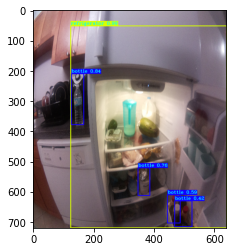

In [17]:
model = recognizer.get_model()
detector = DetectImage()
img_detect = detector.detect(model, "PLACE_AN_IMAGE_PATH", "/content/work_dir/"+ "coco" + ".names", os.path.join(work_dir, "image_detected.jpg"), show=False)
img_detect = cv.cvtColor(img_detect, cv.COLOR_RGB2BGR)
plt.imshow(img_detect)
plt.show()

**Don't run lesson 1 or 2 to try out lesson 3 because yo will charge another network and you'll get an ValueError due network layers**

# Lesson 3: Evaluate our model
In this lesson you will learn how to evaluate using mAP (Mean Average precision) metric if you want to know how this metric works I recomend you see this post: [https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173](https://)


In [ ]:
yolov3_evaluate = ObjectDetectorYoloV3("yolov3_voc_evaluate", 20, training=False) 
recognizer = Recognizer(yolov3_evaluate)

In [ ]:
recognizer.restore_weights("PLACE_YOUR_CHECKPOINT_PATH_LIKE_TENSORFLOW_FORMAT", True)

In [ ]:
model = recognizer.get_model()
classes_path = "/content/work_dir/VOC_classes.txt"
test_dataset_path = "/content/work_dir/val.txt"
test_set = YoloV3DatasetGenerator(test_dataset_path, classes_path)
recognizer.evaluate(model, test_set, classes_path, iou_threshold=0.75)